In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.autograd import Variable

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

from torch.distributions.normal import Normal
from matplotlib import gridspec
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(3)

In [2]:
# agrmax(target) = 2
def target(x):
    return 3* torch.exp(-(x - 2)**2) + 2*torch.exp(-(x - 6)**2/8) + 1/ (x**2 + 1) +torch.randn(x.size()) * .1

# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(-5, 15, 6))
# True function with Gaussian noise N(0,0.01)
train_y = Variable(target(train_x))

#true target (unknown)
x = Variable(torch.linspace(-5, 15, 1000))
y = Variable(target(x))

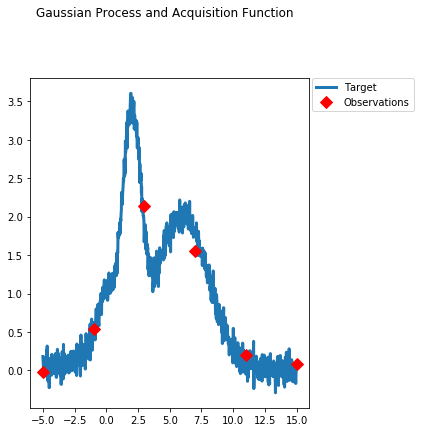

In [3]:
# plotting gp 
def plot_gp(train_x, train_y, x, y, rand_var=None, model=False, acq = None, bo=False):
    fig = plt.figure(figsize=(5,10))
    gs = gridspec.GridSpec(2,1,height_ratios=[2, 1]) 
    axis = plt.subplot(gs[0])
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(train_x, train_y, 'D', markersize=8, label=u'Observations', color='r')
    fig.suptitle('Gaussian Process and Acquisition Function',fontdict={'size':30})
    # if model is trained 
    if model == True:
        lower, upper = rand_var.confidence_region()
        mean = rand_var.mean().data.numpy()
        var = rand_var.var().data.numpy()
        axis.plot(x, mean, '--', color='k', label='Prediction')
       # axis.fill_between(x, lower.data.numpy(), upper.data.numpy(), alpha=.6, label='95% confidence interval')
        axis.fill_between(x, y - 1.96 * var , y + 1.96 * var, alpha=.3, label='95% confidence interval')
    
    # if acqusition function is available
    if bo == True:
        acqusition = plt.subplot(gs[1])
        acqusition.plot(x, acq.data.numpy(), label='Utility Function', color='purple')
        acqusition.plot(x[torch.argmax(acq)], torch.max(acq).data.numpy(), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
        acqusition.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
# target function and observations 
plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy())

In [4]:
print(y.max())

tensor(3.6022)


In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-5,15]
        self.mean_module = ConstantMean(constant_bounds=(-5,15))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return model output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [6]:
# train model to get the hypeparameters 
def train_model(model,train_x,train_y):   
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 10
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
            i + 1, training_iter, loss.data[0],
            model.covar_module.log_lengthscale.data[0, 0],
            model.likelihood.log_noise.data[0]
        ))
        optimizer.step()


In [7]:
# predict
def eval_model(model,likelihood):   
    # Put model and likelihood into eval mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with gpytorch.fast_pred_var():
        observed_pred = likelihood(model(x))
    return observed_pred

In [8]:
#acquisition function using upper confidence bound 
def ucb(observed_pred, kappa=5):
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    acq = mean + kappa * std
    return acq,torch.argmax(acq)

In [9]:
# expected improvement 
def ei(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = (mean - y_max) * Normal(0,1).cdf(z) + std * Normal(0,1).log_prob(z).exp()
    return acq, torch.argmax(acq)

In [10]:
# probability of improvement
def poi(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = Normal(0,1).cdf(z) 
    return acq, torch.argmax(acq)

In [11]:
# Define the CDF of the function upper bound.
def prob(mean, std, z):
    return Normal(0,1).cdf((z-mean) / std)

In [12]:
def find_true_max(observed_pred,train_y):
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    
    #find sample range[left,right]
    left = torch.max(train_y)
    if prob(left) < 0.25:
        right = max(mean + 5 * std);
        while (prob(right) < 0.75):
            right = right + right - left;
    
    

In [13]:
# max value entropy search
def mes(observed_pred):
    with gpytorch.beta_features.fast_pred_var(), gpytorch.beta_features.fast_pred_samples():
    
        f_samples = observed_pred.sample(100)
        y_star_sample = f_samples.max(dim=0)

        y_max = y_star_sample[0].repeat(1000,1).t()

        mean = observed_pred.mean()
        std = torch.sqrt(observed_pred.var())

        gamma = (y_max - mean ) / std
        acq =  gamma * Normal(0,1).log_prob(gamma).exp() / (2 *  Normal(0,1).cdf(gamma)) - torch.log(Normal(0,1).cdf(gamma))

        acq = acq.sum(dim =0) / 100
        index = torch.argmax(acq)

    return acq, index

Iter 1/10 - Loss: 3.995   log_lengthscale: 0.000   log_noise: -6.000
Iter 2/10 - Loss: 3.924   log_lengthscale: 0.100   log_noise: -6.000
Iter 3/10 - Loss: 3.863   log_lengthscale: 0.192   log_noise: -6.000
Iter 4/10 - Loss: 3.811   log_lengthscale: 0.284   log_noise: -6.000
Iter 5/10 - Loss: 3.768   log_lengthscale: 0.372   log_noise: -6.000
Iter 6/10 - Loss: 3.747   log_lengthscale: 0.460   log_noise: -6.032
Iter 7/10 - Loss: 3.740   log_lengthscale: 0.550   log_noise: -6.087
Iter 8/10 - Loss: 3.739   log_lengthscale: 0.642   log_noise: -6.154
Iter 9/10 - Loss: 3.729   log_lengthscale: 0.733   log_noise: -6.232
Iter 10/10 - Loss: 3.706   log_lengthscale: 0.827   log_noise: -6.315
Iter 1/10 - Loss: 3.480   log_lengthscale: 0.000   log_noise: -6.000
Iter 2/10 - Loss: 3.447   log_lengthscale: 0.100   log_noise: -6.100
Iter 3/10 - Loss: 3.395   log_lengthscale: 0.194   log_noise: -6.200
Iter 4/10 - Loss: 3.331   log_lengthscale: 0.284   log_noise: -6.300
Iter 5/10 - Loss: 3.418   log_len

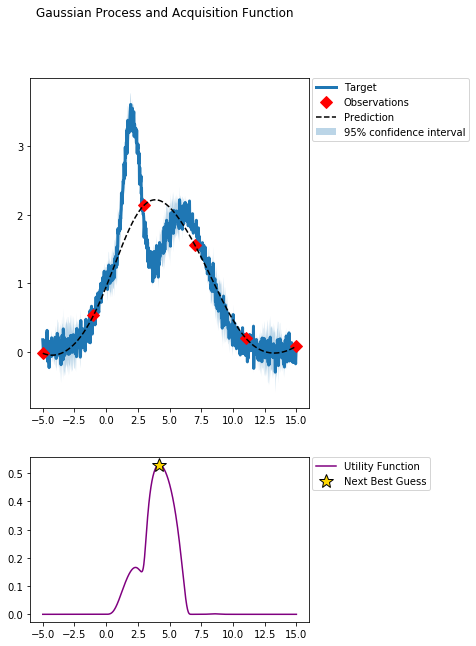

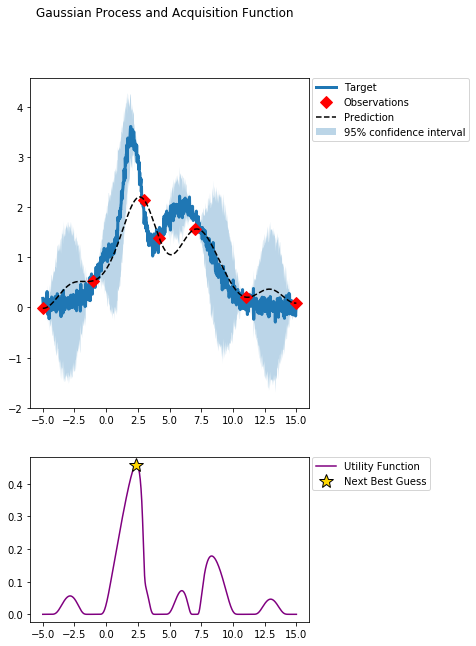

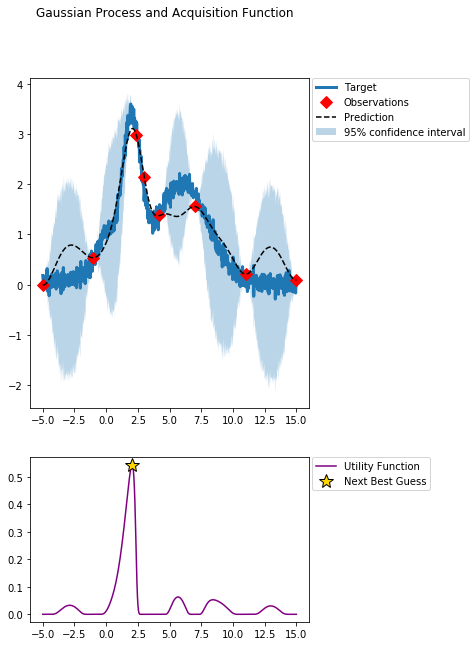

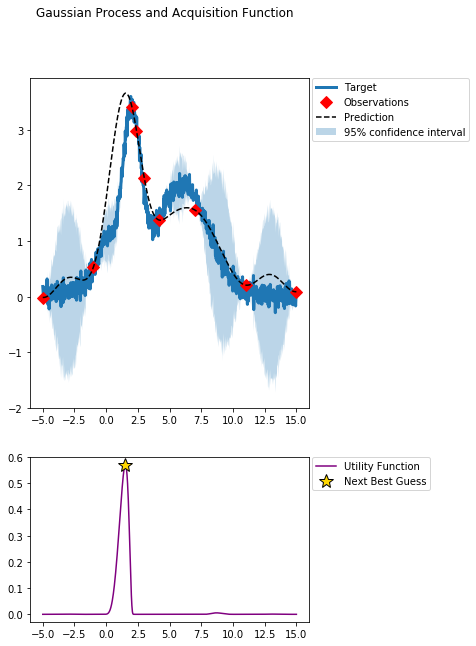

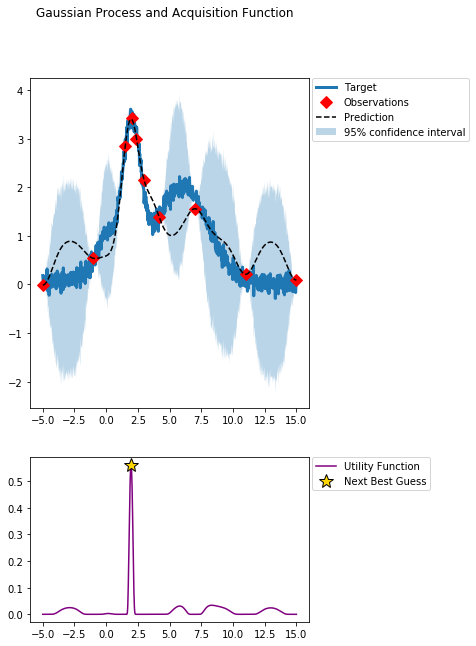

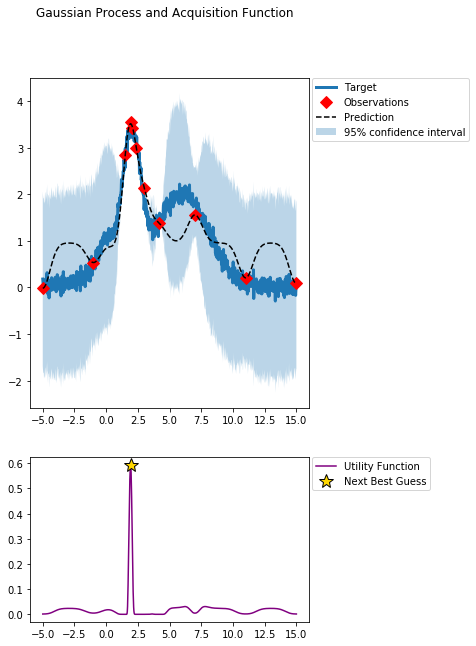

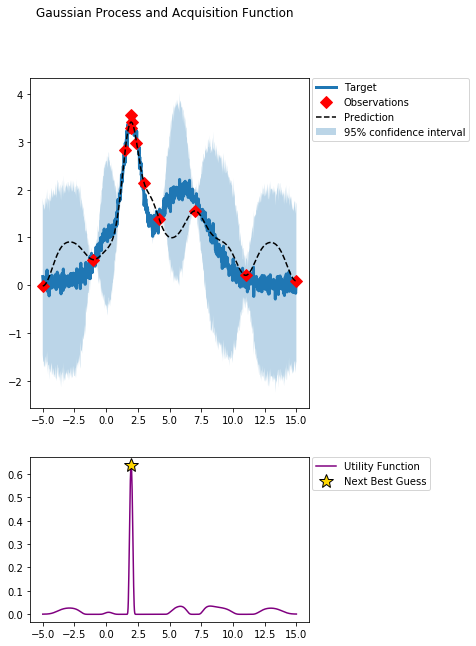

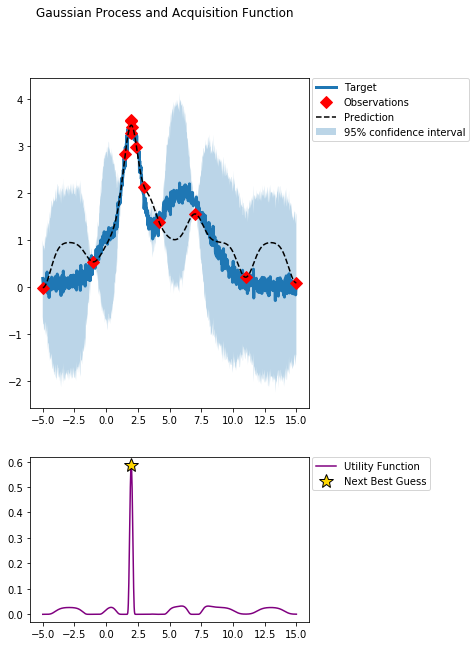

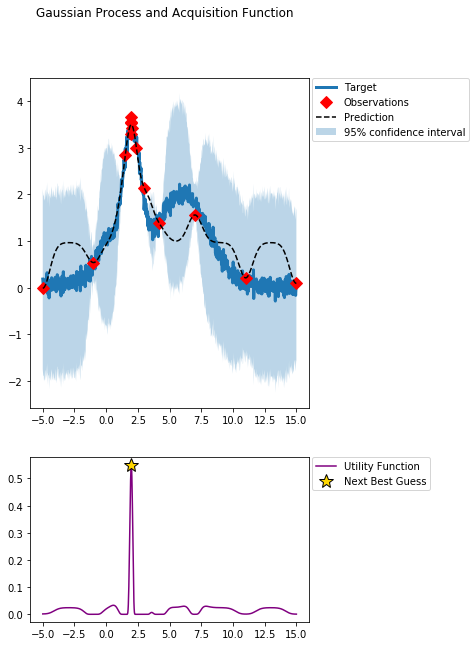

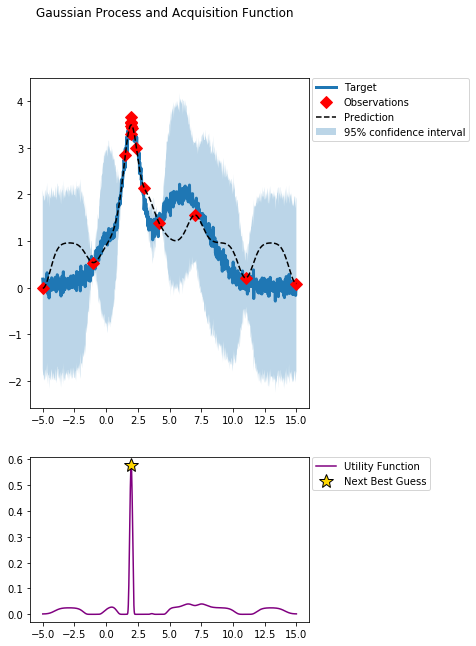

In [14]:
#
iteration = 10
for i in range(iteration):
    # initialize likelihood and model
    likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
    model = ExactGPModel(train_x.data, train_y.data, likelihood)

    #train model
    train_model(model,train_x,train_y)
    observed_pred = eval_model(model,likelihood)
    #choose acquisition function 
    

    #acq,index = ucb(observed_pred)
    #acq,index = ei(observed_pred,train_y)
    #acq,index = poi(observed_pred,train_y)
    acq,index = mes(observed_pred)
    
    
    
    xx = Variable(x[index]).view(1)
    yy = target(xx)
    plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy(), observed_pred, True, acq, True)

    # append the next best guess into training set 
    train_x = torch.cat((train_x,xx))
    train_y = torch.cat((train_y,yy))

In [15]:
torch.cuda.current_device()

3